In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

# Задание 1.
Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [2]:
reg_data = pd.read_csv('C:/Users/nekia/AAA/karpov_projects/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('C:/Users/nekia/AAA/karpov_projects/problem1-auth_data.csv', sep=';')

In [3]:
reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [4]:
# Проведу EDA.

print(reg_data.info(), reg_data.reg_ts.nunique(), sep='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB
None

1000000


In [5]:
auth_data

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [6]:
print(auth_data.info(), auth_data.auth_ts.nunique(), sep='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB
None

9180915


In [7]:
reg_data['datetime_reg'] = pd.to_datetime(reg_data.reg_ts, unit='s')
auth_data['datetime_auth'] = pd.to_datetime(auth_data.auth_ts, unit='s')
print(reg_data.datetime_reg.describe(datetime_is_numeric=True),
      auth_data.datetime_auth.describe(datetime_is_numeric=True), sep='\n\n')

count                          1000000
mean     2019-01-24 12:12:34.523666688
min                1998-11-18 09:43:43
25%         2018-06-03 13:55:11.500000
50%                2019-07-30 02:35:25
75%         2020-04-01 16:28:40.500000
max                2020-09-23 15:17:24
Name: datetime_reg, dtype: object

count                          9601013
mean     2019-01-29 16:12:06.254851584
min                1998-11-18 09:43:43
25%                2018-06-07 12:40:47
50%                2019-07-31 12:43:16
75%                2020-04-02 10:25:21
max                2020-09-23 15:17:24
Name: datetime_auth, dtype: object


In [8]:
reg_data['YM_reg'] = reg_data.datetime_reg.dt.to_period('M')
auth_data['YM_auth'] = auth_data.datetime_auth.dt.to_period('M')
reg_data['Y_reg'] = reg_data.datetime_reg.dt.year
auth_data['Y_auth'] = auth_data.datetime_auth.dt.year
reg_data['reg_date'] = reg_data.datetime_reg.dt.date.astype('datetime64')
auth_data['auth_date'] = auth_data.datetime_auth.dt.date.astype('datetime64')

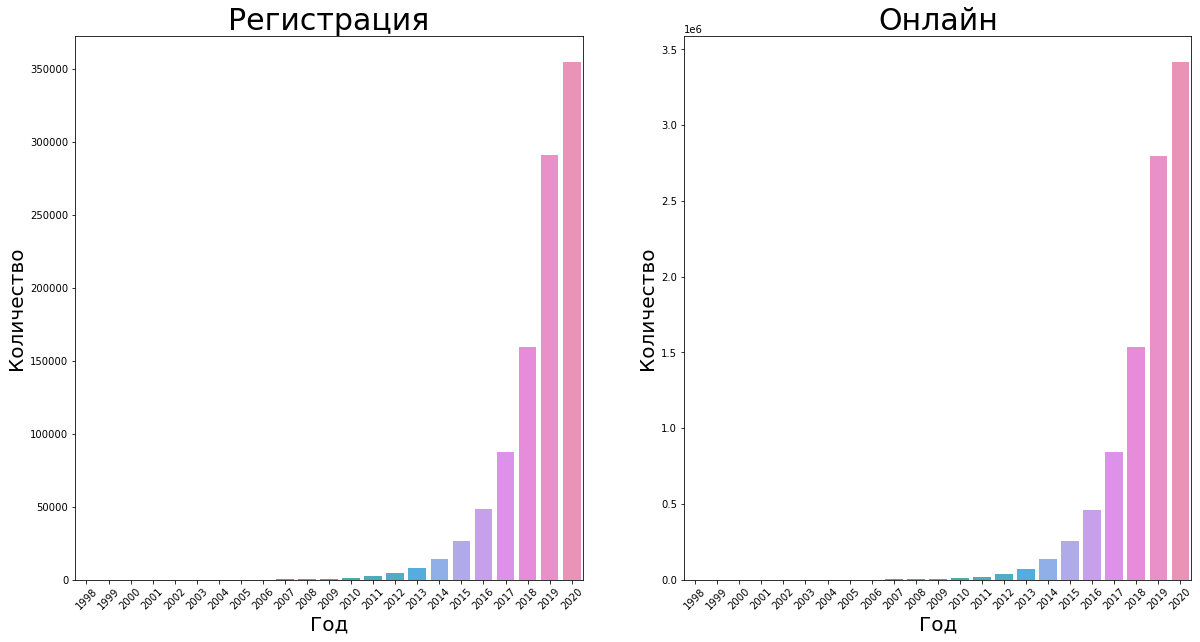

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for i, data in enumerate([reg_data, auth_data]):
    ax[i].set_xticklabels(labels=data.Y_reg.unique() if i == 0 else data.Y_auth.unique(), rotation=45)
    ax[i].set_title("Регистрация" if i == 0 else "Онлайн")
    ax[i].title.set_size(30)
    ax[i].xaxis.label.set_size(20)
    ax[i].yaxis.label.set_size(20)
    sns.countplot(data=data, x='Y_reg' if i == 0 else 'Y_auth', ax=ax[i])
    ax[i].set_xlabel("Год")
    ax[i].set_ylabel("Количество")

In [10]:
def first_task(start, end, days, reg_df=None, auth_df=None, df=None):
    '''
    Функция для подсчета retention.
    Принимает на вход:
        Период регистрации в формате "год, месяц, день", "год, месяц, день".
        Дней на вывод retention.
        Два DataFrame через reg_df= , auth_df=:
            С колонками в данном порядке reg_df[['дата регистрации', 'id пользователя']]
                                         auth_df[['дата активности', 'id пользователя']]
        Или один DataFrame через df=, с колонками в данном порядке:
            [['айди пользователя', 'дата активности', 'дата регистрации']]
    На выходе функция возвращает DataFrame с посчитанным retention.
    '''
    
    if df is None:
        reg_df_cols = reg_df.columns
        auth_df_cols = auth_df.columns
        reg_df.rename(columns={reg_df_cols[0]: 'reg_date', reg_df_cols[1]: 'user_id'}, inplace=True)
        auth_df.rename(columns={auth_df_cols[0]: 'auth_date', auth_df_cols[1]: 'user_id'}, inplace=True)
        
        reg_df.reg_date = pd.to_datetime(reg_df.reg_date, unit='s')
        auth_df.auth_date = pd.to_datetime(auth_df.auth_date, unit='s')
        reg_df.reg_date = reg_df.reg_date.dt.date.astype('datetime64')
        auth_df.auth_date = auth_df.auth_date.dt.date.astype('datetime64')
        
        reg_df = reg_df.query('@start <= reg_date <= @end')
        auth_df = auth_df.query('auth_date >= @start')
        retention = reg_df.merge(auth_df, on='user_id')
        
        retention = retention[['user_id', 'auth_date', 'reg_date']]
        retention = retention.groupby(['reg_date', 'auth_date'], as_index=False).agg({'user_id': 'nunique'})
        retention['period'] = (retention["auth_date"] - retention["reg_date"]).dt.days

        retention_pivot = pd.pivot_table(retention, index="reg_date", columns='period', values='user_id')
        retention_pivot = retention_pivot.iloc[:, : days + 1]

        retention_perc = retention_pivot.divide(retention_pivot.iloc[:, 0], axis=0)
        retention_perc[0] = retention_pivot[0]
        retention_perc.iloc[:, 1:] = retention_perc.iloc[:, 1:].multiply(100).round(2)
        
    else:
    
        current_cols = df.columns
        df.rename(columns={current_cols[0]: 'user_id', current_cols[1]: 'auth_date', current_cols[2]: 'reg_date'},
                  inplace=True)
        retention = df.query('@start <= reg_date <= @end')    
        retention = retention.groupby(['reg_date', 'auth_date'], as_index=False).agg({'user_id': 'nunique'})
        retention['period'] = (retention["auth_date"] - retention["reg_date"]).dt.days

        retention_pivot = pd.pivot_table(retention, index="reg_date", columns='period', values='user_id')
        retention_pivot = retention_pivot.iloc[:, : days + 1]

        retention_perc = retention_pivot.divide(retention_pivot.iloc[:, 0], axis=0)
        retention_perc[0] = retention_pivot[0]
        retention_perc.iloc[:, 1:] = retention_perc.iloc[:, 1:].multiply(100).round(2)
        
    return retention_perc


def heat_map(df, hmap_start, hmap_end, hmap_days, width, height):
    '''
    Функция дополняющая предыдущую и выводящая heatmap.
    Принимает на вход:
        DataFrame из предыдущей функции, период регистрации в формате "год, месяц, день", "год, месяц, день".
        Дней для построения heatmap и ширину с длинной.
    Строит heatmap.
    '''
    
    hmap = df.query('@hmap_start < = reg_date <= @hmap_end')
    hmap = hmap.iloc[:, :hmap_days + 1]
    hmap.index = hmap.index.strftime('%Y %B %d')
    plt.figure(figsize=(width, height))
    sns.heatmap(hmap, annot=True, vmin=hmap.iloc[:, 1:].min().min(), vmax=hmap.iloc[:, 1:].max().max(),
                fmt='g', annot_kws={'size': 20})
    plt.xlabel('')
    plt.ylabel('')

In [11]:
test = reg_data.merge(auth_data, on='uid')

In [12]:
a = first_task('2019-01-01', '2020-01-31', 30,
               reg_df=reg_data[['reg_ts', 'uid']],
               auth_df=auth_data[['auth_ts', 'uid']])
a

period,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,583.0,2.06,3.77,4.97,4.46,6.35,8.23,5.83,5.49,6.00,...,5.49,3.09,4.29,3.77,3.26,4.29,3.60,4.12,2.92,2.23
2019-01-02,583.0,1.72,4.97,3.60,4.97,8.06,5.49,7.03,3.09,4.12,...,3.60,3.95,3.60,2.23,3.26,2.40,3.95,1.89,3.09,2.40
2019-01-03,585.0,1.71,3.08,4.44,5.98,6.32,6.50,5.81,2.22,4.96,...,3.42,3.59,2.39,3.76,4.27,3.25,4.27,2.74,2.22,2.05
2019-01-04,585.0,2.74,3.76,4.27,5.47,5.47,8.03,5.30,4.27,5.30,...,4.27,3.59,3.25,2.91,4.44,3.76,3.76,3.25,1.88,3.42
2019-01-05,586.0,1.88,4.10,4.61,4.95,8.19,7.17,7.00,5.97,4.10,...,4.27,5.29,2.73,4.78,2.90,3.92,4.10,4.10,3.24,3.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,1108.0,1.71,3.52,4.69,5.42,5.14,7.40,5.32,4.33,6.14,...,3.70,3.88,2.62,3.79,3.70,4.15,2.62,3.07,2.80,2.71
2020-01-28,1110.0,2.43,4.41,5.14,6.49,5.50,6.40,5.41,4.32,6.04,...,3.69,3.96,3.33,4.14,3.60,2.88,4.14,2.52,3.33,2.88
2020-01-29,1111.0,2.16,4.05,4.23,4.86,6.12,5.94,6.21,4.77,4.32,...,3.15,3.06,3.78,2.43,2.52,3.15,2.43,2.88,2.52,2.34


In [13]:
a = first_task('2019-01-01', '2020-01-31', 30, df=test[['uid', 'auth_date', 'reg_date']])
a

period,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,583.0,2.06,3.77,4.97,4.46,6.35,8.23,5.83,5.49,6.00,...,5.49,3.09,4.29,3.77,3.26,4.29,3.60,4.12,2.92,2.23
2019-01-02,583.0,1.72,4.97,3.60,4.97,8.06,5.49,7.03,3.09,4.12,...,3.60,3.95,3.60,2.23,3.26,2.40,3.95,1.89,3.09,2.40
2019-01-03,585.0,1.71,3.08,4.44,5.98,6.32,6.50,5.81,2.22,4.96,...,3.42,3.59,2.39,3.76,4.27,3.25,4.27,2.74,2.22,2.05
2019-01-04,585.0,2.74,3.76,4.27,5.47,5.47,8.03,5.30,4.27,5.30,...,4.27,3.59,3.25,2.91,4.44,3.76,3.76,3.25,1.88,3.42
2019-01-05,586.0,1.88,4.10,4.61,4.95,8.19,7.17,7.00,5.97,4.10,...,4.27,5.29,2.73,4.78,2.90,3.92,4.10,4.10,3.24,3.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,1108.0,1.71,3.52,4.69,5.42,5.14,7.40,5.32,4.33,6.14,...,3.70,3.88,2.62,3.79,3.70,4.15,2.62,3.07,2.80,2.71
2020-01-28,1110.0,2.43,4.41,5.14,6.49,5.50,6.40,5.41,4.32,6.04,...,3.69,3.96,3.33,4.14,3.60,2.88,4.14,2.52,3.33,2.88
2020-01-29,1111.0,2.16,4.05,4.23,4.86,6.12,5.94,6.21,4.77,4.32,...,3.15,3.06,3.78,2.43,2.52,3.15,2.43,2.88,2.52,2.34


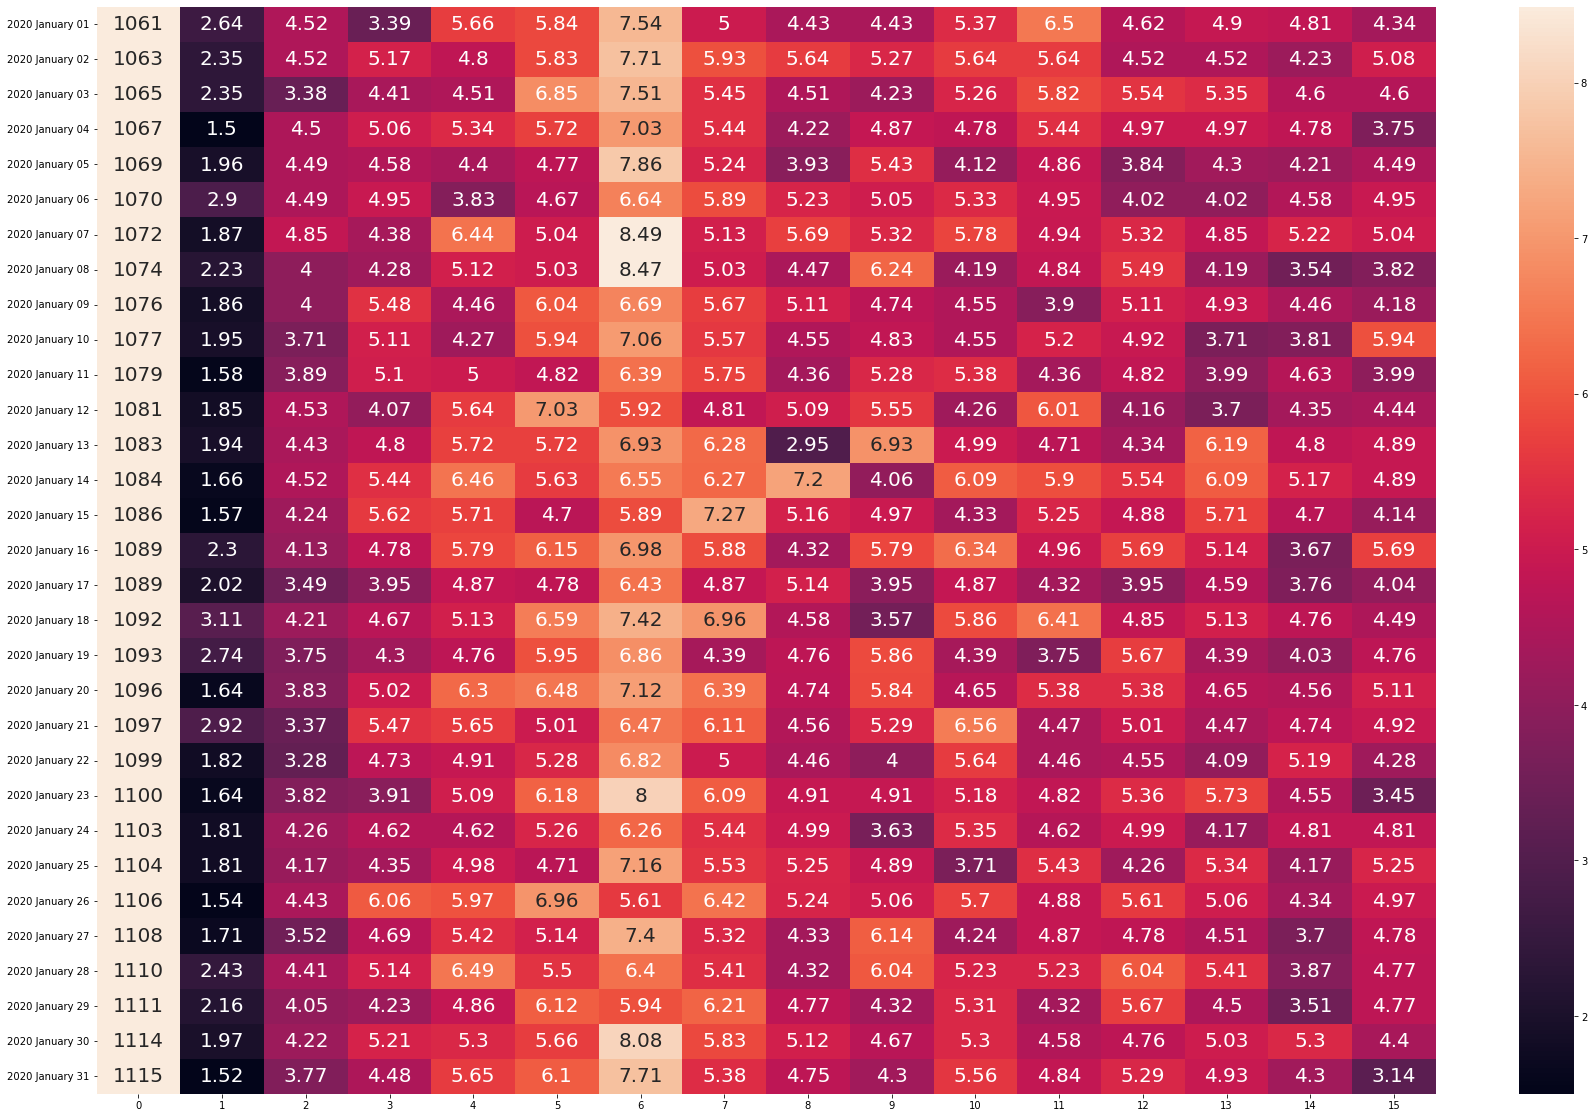

In [14]:
heat_map(a, "2020-01-01", "2020-01-31", 15, 30, 20)

# Задание №2.
Двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [15]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
public_key = response.json()['href']
df = pd.read_csv(public_key, sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [16]:
# Проведу EDA.

info = df.info()
rev_a = df.query('testgroup == "a"').revenue.describe()
rev_b = df.query('testgroup == "b"').revenue.describe()
df_a, df_b = df.query('testgroup =="a"'), df.query('testgroup =="b"')
sum_a, sum_b = df_a.revenue.sum(), df_b.revenue.sum()
print(info, rev_a, rev_b, 'Доход в группе A: {}'.format(sum_a), 'Доход в группе B: {}'.format(
    sum_b), 'Доход в группе B больше на: {}'.format(sum_b - sum_a), sep='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB
None

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

Доход в группе A: 5136189

Доход в группе B: 5421603

Доход в группе B больше на: 285414


<AxesSubplot:title={'center':'TestGroup'}, xlabel='revenue'>

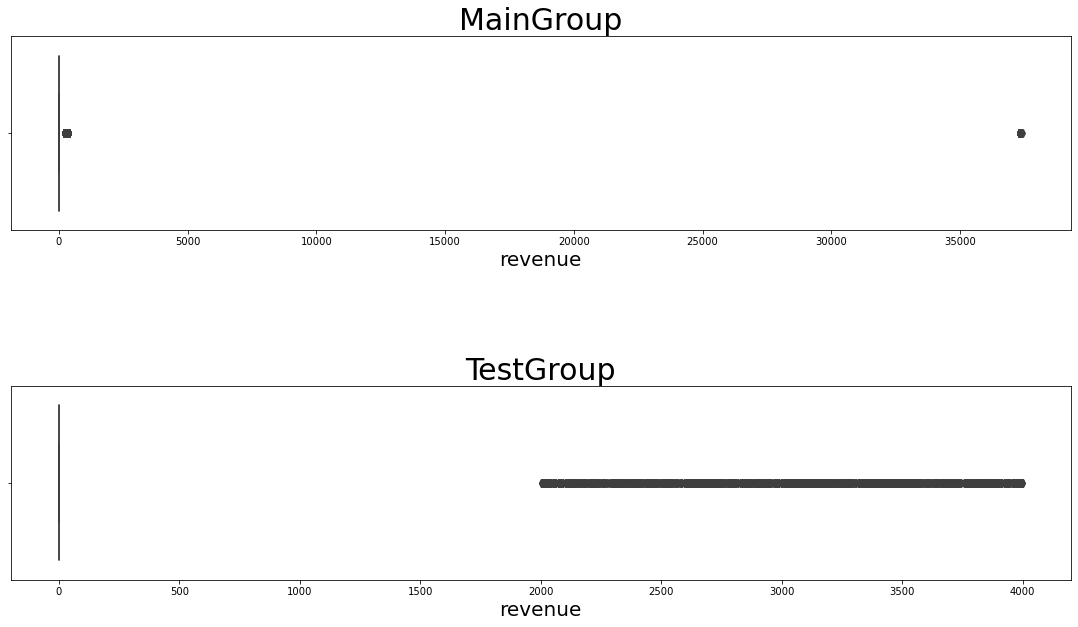

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(19, 10))

ax1.set(title='MainGroup')
ax2.set(title='TestGroup')
ax1.title.set_size(30)
ax1.xaxis.label.set_size(20)
ax2.title.set_size(30)
ax2.xaxis.label.set_size(20)
plt.subplots_adjust(hspace=0.8)
sns.boxplot(data=df_a, x='revenue', ax=ax1)
sns.boxplot(data=df_b, x='revenue', ax=ax2)

In [18]:
df_a.revenue.quantile(q=0.99)

0.0

In [19]:
# Describe без "выбросов". % людей принесли основной доход.
print(df_a.query('revenue <=30000').revenue.describe(), df_b.query('revenue < 2000').revenue.describe(),
      '30к+ в группе А: {}'.format(df_a.query('revenue > 30000').shape[0]), '2k-4k в группе B: {}'.format(
          df_b.query('2000 <= revenue <= 4000').shape[0]),
      '% людей в группе А: {}'.format(
          round(df_a.query('revenue > 30000').shape[0] / df_a.shape[0] * 100, 3)),
      '% людей в группе B: {}'.format(
          round(df_b.query('2000 <= revenue <= 4000').shape[0] / df_b.shape[0] * 100, 3)),
      sep='\n\n')

count    201980.000000
mean          2.702926
std          28.985815
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         400.000000
Name: revenue, dtype: float64

count    200862.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: revenue, dtype: float64

30к+ в группе А: 123

2k-4k в группе B: 1805

% людей в группе А: 0.061

% людей в группе B: 0.891


### Посчитаю метрики

ARPU = Конверсия ⋅ ARPPU

Конверсия = Число клиентов / Число пользователей 

ARPPU =  Доход / Число клиентов 

Пользователь – это любой человек, который взаимодействовал с вашим продуктом.

Клиент – как правило, это пользователь, который совершил ключевое действие (покупку).

In [20]:
cr_a = df_a.query('revenue > 0').shape[0] / df_a.shape[0]
cr_b = df_b.query('revenue > 0').shape[0] / df_a.shape[0]


arppu_a = df_a.revenue.sum() / df_a.query('revenue > 0').shape[0]
arppu_b = df_b.revenue.sum() / df_b.query('revenue > 0').shape[0]


arpu_a = cr_a * arppu_a
arpu_b = cr_b * arppu_b


info = {'CR_A': str(round(cr_a * 100, 3)) + '%',
        'CR_TEST': str(round(cr_b * 100, 3)) + '%',
        'ARPPU_A': round(arppu_a, 3),
        'ARPPU_TEST': round(arppu_b, 3),
        'ARPU_A': round(arpu_a, 3),
        'ARPU_TEST': round(arpu_b, 3)}
info

{'CR_A': '0.954%',
 'CR_TEST': '0.893%',
 'ARPPU_A': 2663.998,
 'ARPPU_TEST': 3003.658,
 'ARPU_A': 25.414,
 'ARPU_TEST': 26.826}

In [21]:
# Сравню CR двух групп используя таблицу сопряженности и хи-квадрат.

from scipy.stats import chi2_contingency

table = pd.crosstab(df["testgroup"], df["revenue"] > 0)
chi2, p, dof, expected = chi2_contingency(table)
print("Chi-squared test statistic: {:.3f}".format(chi2))
print("p-value: {:.3f}".format(p))

Chi-squared test statistic: 4.375
p-value: 0.036


Тест на нормальность распределения control группы: W = 0.999 , p-value = 0.000 => стат значимо не нормально
Тест на нормальность распределения target группы: W = 1.000 , p-value = 0.981 => не стат значимо, нормальное


Text(0.5, 1.0, 'Group B')

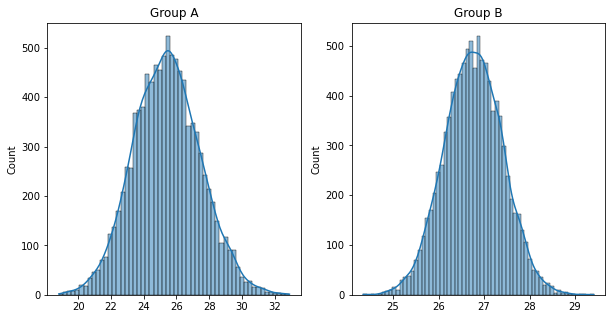

In [22]:
# Перед использованием t-test, проверю распределение средних.

a = []
b = []

for i in range(10000):
    sample_a = df_a.revenue.sample(frac=1, replace=True)
    sample_b = df_b.revenue.sample(frac=1, replace=True)
    a.append(sample_a.mean())
    b.append(sample_b.mean())


sp = stats.shapiro(a)
concl = '=> не стат значимо, нормальное' if sp[
    1] > 0.05 else '=> стат значимо не нормально'
print('Тест на нормальность распределения control группы: W = %.3f' %
      sp[0], ', p-value = %.3f' % sp[1], concl)

sp = stats.shapiro(b)
concl = '=> не стат значимо, нормальное' if sp[
    1] > 0.05 else '=> стат значимо не нормально'
print('Тест на нормальность распределения target группы: W = %.3f' %
      sp[0], ', p-value = %.3f' % sp[1], concl)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data=a, kde=True, ax=ax1).set_title('Group A')
sns.histplot(data=b, kde=True, ax=ax2).set_title('Group B')

In [23]:
stats.levene(df_a.revenue, df_b.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Тест Шапиро-Уилка показывает, что распределение группы А стат значимо не нормально, но визуально оно плюс минус ок.  
Дисперсии примерно равны.  
Проведу t-test.

In [24]:
print(stats.ttest_ind(df_a.revenue, df_b.revenue))
print(stats.ttest_ind(df_a.query('revenue > 0').revenue, df_b.query('revenue > 0').revenue))

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)
Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)


## Итог.
Из EDA имеем:\
В контрольной группе 89.4% дохода было от 0.061% - 123 человека, от которых было получено 37к+.\
В тестовой группе 100% дохода было от 0.89% -  1805 человек, от которых было полученно от 2к до 4к.\
В задании не было дано информации о наборах предложений, из-за данного разброса revenue можно предположить, что они очень сильно различаются по цене - один состоит из очень дешевых до 400 плюс очень дорогих 35k+, другой из 2к-4к. Можно провести еще один тест включив оба набора предложений в одну группу. Возможно, доход будет больше, тк для пользователей имеющих возможность платить больше, будет доступен "жирный" вариант, а для пользователей не имеющий такой возможности - обычный.  
Но если возможности провести еще один тест нет, то, основываясь на результатах проведенного t-test, можно сделать вывод о том, что разница между ними отсутствует. Однако, тест хи квадрат показал, что разница между конверсиями имеет стат значимость, конверсия в группе А выше. Предлагаю оставить набор предложений использовавшийся для группы А.

Если же наборы были +- одинаковы, то у нас присутствует проблема со сплит системой, разница между пользователями по пункту платежеспособности невероятно велика. Необходимо починить систему сплитования и провести тест заново.

# Задание №3.
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

До механики:  

•Доход из источников не связанных с ивентом.  

•Если предусмотрено прохождение уровней за деньги, то доход из этого источника.  
Можно балансировать сложность и смотреть на каком уровне мы получаем наибольший доход из этого источника, при этом не проседая по другим метрикам.  

•Доход из остальных источников, связанных с событием.  
Эта метрика позволяет оценить все источники дохода, которые связаны с событием, включая рекламу, покупки в игре и т.д. 

•Кол-во участников.  
Знать в целом кол-во игроков.  

•Кол-во новых игроков, чтобы сравнить с кол-вом новых игроков после запуска ивента.  

•Кол-во игроков вернувшихся в игру из за ивента.  
Как много людей заходят в игру только на время ивента. Некоторые игры живут только засчет новых ивентов.

•Конверсия события - доля игроков, которые начали участвовать в событии, относительно общего числа игроков.  
Понимать насколько событие интересно для пользователей.  

•Доля игроков, достигших конечного уровня события, относительно общего числа игроков, начавших участвовать в событии.  
Баланс сложности, контроль churn и retention.  

•Retention.  
•Churn-rate. Отток. Сдавшиеся игроки.  
•Время прохождение уровня. В целом потраченное на игру время.  
•Неудачные попытки на уровень. Чтобы можно было балансировать.  

После добавления механики неудачные попытки на уровень заменились бы на среднее число откатов на каждом уровне. 

Метрики помогут понять различные аспекты ивента, вовлеченность игроков, доход, баланс сложности.

В случае просадки многих метрик необходимо разобраться:   
Доход из источников не связанных с ивентом, если это основной источник дохода.    
Конверсией в ивент. Это показывает интерес и увлеченность среди игроков.  
Кол-вом игроком дошедших до конца тк это могло бы дать понять сложность данного события и увлеченность.  
Retention. Насколько хорошо игра удерживает игроков.  

В дальнейшем нужно разобраться с:  
Кол-во затраченного времени на уровень.  
Откатов с уровня.  
Доход с ивента.


